# CNN_transfer_features

- In [`sdss_CNN`](https://github.com/Chris-Duckworth/sdss_CNN), a convolutional neural network (CNN) was developed to predict a galaxy's spin based on a galaxy image. Here we are looking to cluster together these galaxy images, to identify distinct groups (as opposed to classical morphological groups).
- We will use _transfer_ learning of the trained network to characterise a given galaxy's _features_ (i.e. remove the last few layers that aim to reproduce a galaxy's spin).
    - We can also use alternative state-of-the-art networks (e.g. vgg16 or xception) to see if this yields better results.
- To compress the number of features used in the clustering (i.e. new output layer of nodes), we can use principal component analysis (PCA) to return new features that explain maximal variance about the dataset.
- Finally, these compressed features will be the input of clustering algorithms to group together the galaxy images.

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

### Loading CNN from `sdss_CNN`
- Network structure consists of 5 convolutional blocks, followed by flattening and 3 fully connected layers.
- In its current format the CNN results in a prediction for galaxy spin (i.e. a continous variable between 0 and 1).
- To generate dimensions that better represent the galaxy images, we can remove the last few layers - which correspond to fully connected nodes with dropout - i.e. taking direct (flattened) output from convolutional layers for PCA input

In [2]:
model = keras.models.load_model('../../sdss_CNN/NN/final-model/saved-model-35-0.02.hdf5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 75, 64)        6976      
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 71, 71, 96)        153696    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 35, 35, 96)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 35, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       49280     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 128)       0

In [5]:
feature_model = keras.Model(inputs=model.inputs, outputs=model.layers[-5].output)
feature_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 80, 80, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 75, 75, 64)        6976      
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 71, 71, 96)        153696    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 35, 35, 96)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 35, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)      

### Generating CNN feature set for each galaxy image
- Removing last 4/5 `keras` layers results in 128/37632 output features to describe the image data.

In [6]:
# loading in pre-processed data
data_dir = '../../sdss_CNN/data/cleaned_datasets/'
x = np.load(data_dir + 'x.npy')

features = feature_model.predict(x, use_multiprocessing=True) 

### Using PCA to drop highly correlated dimensions.
- Creating variance ratio plot to describe relative importance of PCA features.

In [7]:
# creating pca object
pca = PCA(n_components=100) 
pca.fit(features)
compressed_features = pca.transform(features)

print('The compressed {} features explain {:2.2%} of the variance in the {} output features from the CNN.'.format(pca.n_components_, 
                                                                                                                  np.sum(pca.explained_variance_ratio_),
                                                                                                                  features.shape[1]))


The compressed 100 features explain 94.36% of the variance in the 37632 output features from the CNN.


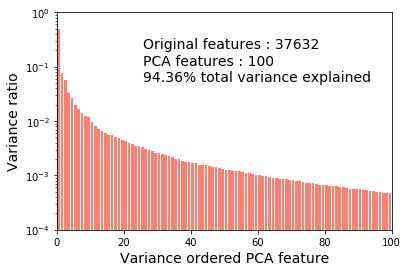

In [8]:
fig = plt.figure()
ax = fig.add_subplot()
ax.bar(np.arange(pca.explained_variance_ratio_.shape[0]) + 0.5, 
       pca.explained_variance_ratio_, 
       color='salmon')

ax.set_xlabel('Variance ordered PCA feature', fontsize=14)
ax.set_ylabel('Variance ratio', fontsize=14)
ax.annotate('Original features : {} \nPCA features : {} \n{:2.2%} total variance explained'.format(features.shape[1], pca.n_components_, np.sum(pca.explained_variance_ratio_)) , (0.35, 0.7), 
            xycoords = 'figure fraction', fontsize=14)
ax.set_xlim([0, pca.n_components_])
ax.set_yscale('log')
ax.set_ylim([10**-4, 1])

plt.savefig('./pca_variance_plots/pca_feature_variance-' + str(features.shape[1]) + '-' + str(pca.n_components_) + '.png',
            format='png', dpi=200, bbox_inches='tight')

### Saving output files of compressed features
- Also saving variance described by each PCA component (might be useful for weighting parameter space in clustering)

In [8]:
np.save('./features/CNN-' + str(features.shape[1]) + '_PCA-' + str(pca.n_components_) + '_features.npy', compressed_features)
np.save('./features/CNN-' + str(features.shape[1]) + '_PCA-' + str(pca.n_components_) + '_weights.npy', pca.explained_variance_ratio_)